In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import matplotlib.pyplot as plt

In [2]:
train_path = 'TRAINDATAnewcols7.16_3year.csv'
test_path = 'TESTDATAnewcols7.16_3year.csv'
predict_path = 'PREDICTDATAnewcols7.16_3year.csv'
lower_alpha_bound = 0
upper_alpha_bound = 100
alpha_iterations = 100
max_iters=1000

In [3]:
def run_lasso_model_scaled(train_path, test_path, predict_path, alpha_lower_bound=0, 
                           alpha_upper_bound=100, alpha_iterations=101, max_iterations=1000, log_y='No', current_rent='No'):
    '''
    Function to run the lasso regression model on our data for the capstone project.
    Need to enter in the path to the data, and then have optional arguments you can enter.
    
    Inputs:
    train_path - name of the training data file, in quotes as a text string.
    test_path - name of the testing data file, in quotes as a text string.
    alpha_lower_bound - lower end of the penalization hyperparameter for the lasso regression. Defaults to 0
    alpha_upper_bound - upper end of the penalization hyperparameter for the lasso regression. Defaults to 100
    alpha_iterations - number of values used in the previously specified range for alpha. Defaults to 101
    max_iterations - maximum iterations for the lasso regression. Defaults to 1,000.
    '''
    # Load the data
    data = pd.read_csv(train_path, index_col=False)
    test_data = pd.read_csv(test_path, index_col=False)
    predict_data = pd.read_csv(predict_path, index_col=False)

            
   # Create X and y for machine learning
    if current_rent in ['No', 'no', 0]:
        train_X = data.drop(['Rent', 'RegionName', 'City', 'State', 'Current Rent'], axis=1)
        test_X = test_data.drop(['Rent', 'RegionName', 'City', 'State', 'Current Rent'], axis=1)
        predict_X = predict_data.drop(['Rent', 'RegionName', 'City', 'State', 'Current Rent'], axis=1)
    elif current_rent in ['Yes', 'yes', 1]:    
        train_X = data.drop(['Rent', 'RegionName', 'City', 'State'], axis=1)
        test_X = test_data.drop(['Rent', 'RegionName', 'City', 'State'], axis=1)
        predict_X = predict_data.drop(['Rent', 'RegionName', 'City', 'State'], axis=1)
    else:
        raise ValueError('Enter Yes or No for current_rent parameter')
    
    print('value of log_y:', log_y)
    
    if log_y in ['No', 'no', 0]:
        train_y = data['Rent']
        test_y = test_data['Rent']
        predict_y = predict_data['Rent']
    elif log_y in ['Yes', 'yes', 1]:
        train_y = np.log(data['Rent'])
        test_y = np.log(test_data['Rent'])
        predict_y = np.log(predict_data['Rent'])
    else:
        raise ValueError('Enter Yes or No for log_y parameter')
    
    
    ## SCALE DATA ## - MinMax or Standardization? or Normalizer? I am thinking standardization, less affected by outliers. 
    train_X_scaled = StandardScaler().fit_transform(train_X)
    test_X_scaled = StandardScaler().fit_transform(test_X)
    predict_X_scaled = StandardScaler().fit_transform(predict_X)
    
    # Create and fit the model
    lasso = Lasso(normalize=False, max_iter=max_iterations)
    lasso_params = {'alpha':np.linspace(alpha_lower_bound,alpha_upper_bound,alpha_iterations)}
    grid_lasso = GridSearchCV(lasso, lasso_params, scoring='r2', n_jobs=-1, cv=5, verbose=2)
    grid_lasso.fit(train_X_scaled, train_y)
    
    # Tell user alpha used
    print('Best alpha: ', grid_lasso.best_params_['alpha'])
    
    # Tell user training score
    print('Score on training data: ', round(grid_lasso.score(train_X_scaled,train_y),3))
    
    # Tell user the croo-validation scores
    print('Scores from 5-fold cross-validation: \n', cross_val_score(grid_lasso, train_X_scaled, train_y, scoring='r2', n_jobs=-1, cv=5))
    
    # Tell user the test score (for zip codes not seen)
    print('Score on TEST data (zip codes not trained on): ', round(grid_lasso.score(test_X_scaled,test_y),3))
    
    # Tell the user the Prediction score (for future years not seen)
    print('Score on PREDICT data (years not trained on): ', round(grid_lasso.score(predict_X_scaled,predict_y),3))
    
    # Get coefs for best model
    best_mod = Lasso(alpha=grid_lasso.best_params_['alpha'], max_iter = max_iterations)
    best_mod.fit(train_X_scaled, train_y)
    coef_list = list(zip(list(train_X.columns), best_mod.coef_))
    print('Total features: ', len(coef_list))
    used_list = []
    for x in coef_list:
        if x[1] != 0:
            used_list.append(x)
    print('Number of Features used: ', len(used_list), '\n')
    print('Used Features, sorted by importance:')
    for x in sorted(used_list, key=lambda x: abs(x[1]), reverse=True):
        print(x)
    
    # Return multicollinearity chart
    feature_names = [x[0] for x in used_list]
    RSquared = []
    variable_name = []
    for var in feature_names:
        dep_var = StandardScaler().fit_transform(np.array(train_X[var]).reshape(-1,1))
        predictors =StandardScaler().fit_transform(train_X.drop(var, axis=1))
        ols = LinearRegression()
        ols.fit(predictors, dep_var)
        variable_name.append(var)
        RSquared.append(ols.score(predictors, dep_var))

    val_dfs = pd.concat([pd.Series(RSquared), pd.Series(variable_name)], axis=1)
    val_dfs = val_dfs.sort_values(by=0, ascending=False)

    # Print multicollinearity info
    print('\nMulticollinearity tests for used variables:\n', val_dfs)    
    
    ## Plotting multicollinearity test from previous project ##
    plt.rcParams["figure.figsize"] = (30,3)
    plt.plot(val_dfs[1], val_dfs[0])
    plt.xticks(rotation=90)
    plt.ylim(0,1)

    plt.show()
    

value of log_y: False
Fitting 5 folds for each of 101 candidates, totalling 505 fits
Best alpha:  0.74
Score on training data:  0.544
Scores from 5-fold cross-validation: 
 [0.57470467 0.48321573 0.48353688 0.52797408 0.66974289]
Score on TEST data (zip codes not trained on):  0.705
Score on PREDICT data (years not trained on):  0.511
Total features:  38
Number of Features used:  36 

Used Features, sorted by importance:
('median_income', 284.928836510354)
('Perc_hispanic', 200.03233906712572)
('total_pop', 198.34548232139232)
('dwellings_1_units', -181.37474873302895)
('Perc_commuter_by_public_transport', 153.26162520287036)
('families_with_young_children_summed', -151.73102685970127)
('walked_to_work', 143.20060240019396)
('Perc_asian', 114.41149584352716)
('dwellings_50_or_more_units', -110.62649992224148)
('million_dollar_housing_units', 93.51773060099397)
('gini_index', 80.67208943886511)
('Perc_different_house_year_ago_same_city', -75.48204308443147)
('dwellings_under_10_units', 

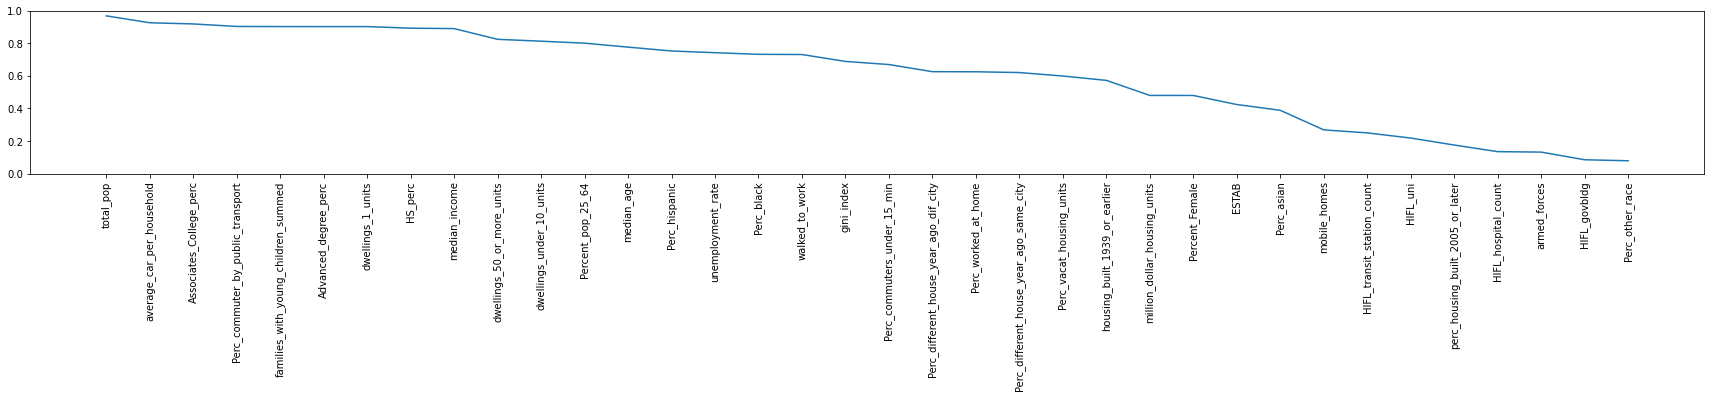

In [4]:
run_lasso_model_scaled(train_path, test_path, predict_path, 0, 1, 101, log_y=False)

value of log_y: True
Fitting 5 folds for each of 101 candidates, totalling 505 fits
Best alpha:  0.00015000000000000001
Score on training data:  0.684
Scores from 5-fold cross-validation: 
 [0.68471894 0.66068526 0.67311947 0.67943842 0.69234988]
Score on TEST data (zip codes not trained on):  0.72
Score on PREDICT data (years not trained on):  0.664
Total features:  38
Number of Features used:  38 

Used Features, sorted by importance:
('total_pop', 0.1658396451272854)
('median_income', 0.14805763307779266)
('dwellings_1_units', -0.14154058320272733)
('Perc_hispanic', 0.13750713369625905)
('families_with_young_children_summed', -0.10636559792152385)
('walked_to_work', 0.07936322536533728)
('dwellings_50_or_more_units', -0.07333516605368592)
('Perc_commuter_by_public_transport', 0.06690215190743187)
('Perc_asian', 0.0647527215540713)
('gini_index', 0.05677239528490207)
('Associates_College_perc', 0.04413170440255181)
('Perc_different_house_year_ago_same_city', -0.04374408845130979)
('P

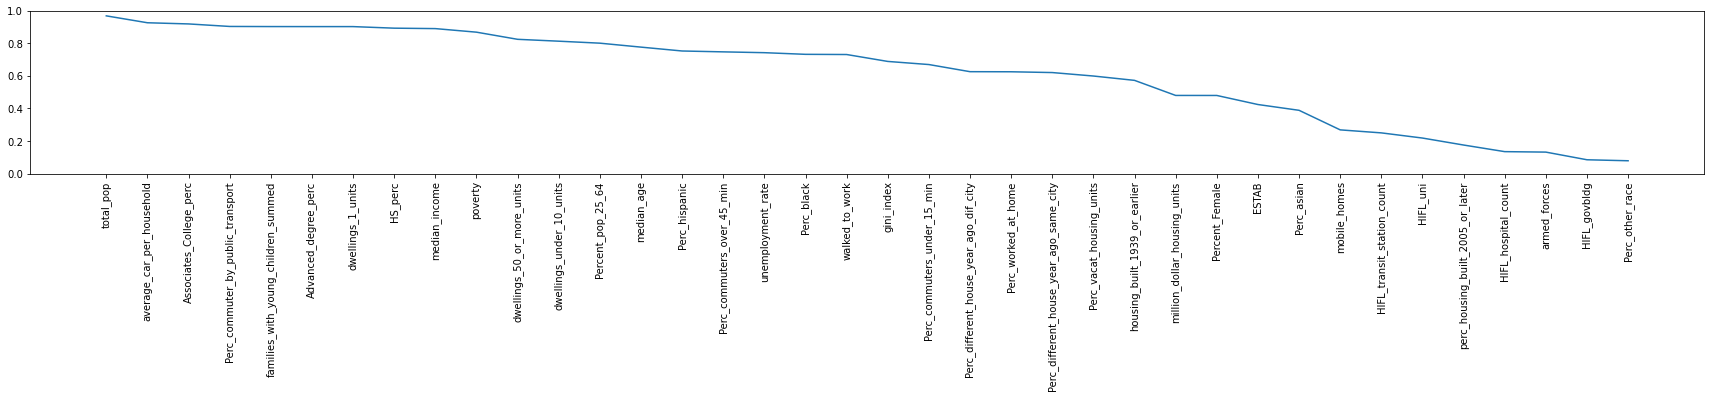

In [5]:
run_lasso_model_scaled(train_path, test_path, predict_path, 0, .001, 101, log_y=True)

# Maybe go log price??

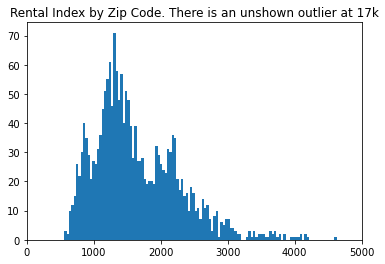

In [55]:
plt.hist(y, bins=500)
plt.xlim(0,5000)
plt.title('Rental Index by Zip Code. There is an unshown outlier at 17k')
plt.show()

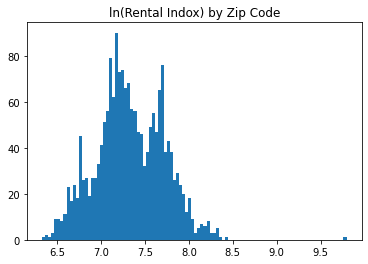

In [56]:
plt.hist(np.log(y), bins=100)
plt.title('ln(Rental Indox) by Zip Code')
plt.show()

## What is an outlier?

In [42]:
len(y[y>3500])

30

In [43]:
len(y)

1858

In [48]:
np.std(np.log(y))

0.3845720106469143

In [49]:
np.mean(np.log(y))

7.329237791578592

In [50]:
np.mean(np.log(y)) + 3*np.std(np.log(y))

8.482953823519335

In [51]:
np.exp(np.mean(np.log(y)) + 3*np.std(np.log(y)))

4831.700830689226